In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import joblib
from sklearn.metrics import ndcg_score
%matplotlib inline

sns.set_style("whitegrid")

data_path   = "D:/Machine Learning Projects/10. Movie Recommender/"
models_path = "D:/Machine Learning Projects/10. Movie Recommender/"

In [5]:
ratings = pd.read_csv(data_path + "ratings_processed.csv")
movies  = pd.read_csv(models_path + "movies_metadata.csv")

# Load mappings
mappings = joblib.load(models_path + "id_mappings.pkl")
user_map         = mappings['user_map']
movie_map        = mappings['movie_map']
inverse_user_map = mappings['inverse_user_map']
inverse_movie_map = mappings['inverse_movie_map']

n_users  = len(user_map)
n_movies = len(movie_map)

print(f"Users: {n_users}, Movies: {n_movies}")

Users: 6040, Movies: 3706


In [12]:
# ────────────────────────────────────────────────────────────────
# First, define the FULL FunkSVD class again (copy from Phase 2)
# ────────────────────────────────────────────────────────────────

class FunkSVD:
    def __init__(self, n_factors=40, n_epochs=30, lr=0.005, reg=0.02, verbose=True):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.verbose = verbose
        
        self.user_factors = None
        self.item_factors = None
        self.user_bias = None
        self.item_bias = None
        self.global_mean = None

    def predict(self, user_idx, movie_idx):
        return (self.global_mean + 
                self.user_bias[user_idx] + 
                self.item_bias[movie_idx] + 
                np.dot(self.user_factors[user_idx], self.item_factors[movie_idx]))

    # You can leave fit() and save() out if you only need prediction now

# ────────────────────────────────────────────────────────────────
# Now load parameters into a fresh instance
# ────────────────────────────────────────────────────────────────

model = FunkSVD()  # creates object with predict method

loaded = np.load(models_path + "funksvd_model.npz")

model.user_factors = loaded['user_factors']
model.item_factors = loaded['item_factors']
model.user_bias    = loaded['user_bias']
model.item_bias    = loaded['item_bias']
model.global_mean  = float(loaded['global_mean'])  # ensure scalar
model.n_factors    = int(loaded['n_factors'])

print("Model loaded with predict method available.")
print(f"User factors shape: {model.user_factors.shape}")
print(f"Item factors shape: {model.item_factors.shape}")

Model loaded with predict method available.
User factors shape: (6040, 40)
Item factors shape: (3706, 40)


In [13]:
# Relevant items = rating >= 4
relevant = ratings[ratings['rating'] >= 4].groupby('user_id')['movie_id'].apply(set).to_dict()

print(f"Number of users with at least one relevant item: {len(relevant)}")

Number of users with at least one relevant item: 6038


In [14]:
# Sample users who have enough ratings (for meaningful metrics)
min_ratings_for_eval = 20
user_counts = ratings['user_id'].value_counts()
eval_users = user_counts[user_counts >= min_ratings_for_eval].index[:1000].tolist()

print(f"Evaluating on {len(eval_users)} users")

Evaluating on 1000 users


In [15]:
# Function to get predicted scores for all movies for a user
def get_user_predictions(user_id):
    if user_id not in user_map:
        return None
    u_idx = user_map[user_id]
    preds = {}
    for m_id, m_idx in movie_map.items():
        score = model.predict(u_idx, m_idx)
        preds[m_id] = score
    return preds

In [16]:
def evaluate_user(user_id, k=10):
    if user_id not in relevant or user_id not in user_map:
        return None
    
    true_relevant = relevant[user_id]
    n_rel = len(true_relevant)
    
    preds = get_user_predictions(user_id)
    if preds is None:
        return None
    
    # Sort movies by predicted score descending
    sorted_items = sorted(preds.items(), key=lambda x: x[1], reverse=True)
    top_k_ids = [mid for mid, _ in sorted_items[:k]]
    
    # Hits = how many top-K are relevant
    hits = len(set(top_k_ids) & true_relevant)
    
    # Precision@K
    prec_k = hits / k
    
    # Recall@K
    rec_k = hits / n_rel if n_rel > 0 else 0
    
    # NDCG@K
    y_true = [1 if mid in true_relevant else 0 for mid in top_k_ids]
    y_score = [preds[mid] for mid in top_k_ids]
    ndcg = ndcg_score([y_true], [y_score], k=k) if sum(y_true) > 0 else 0
    
    return {
        'user_id': user_id,
        'precision_k': prec_k,
        'recall_k': rec_k,
        'ndcg_k': ndcg,
        'hits': hits,
        'n_relevant': n_rel
    }

In [17]:
results = []
for uid in eval_users:
    res = evaluate_user(uid, k=10)
    if res:
        results.append(res)

eval_df = pd.DataFrame(results)
print("Evaluation complete")

Evaluation complete


=== Ranking Metrics @K=10 ===
Precision@10: 0.5817 ± 0.2465
Recall@10:    0.0255 ± 0.0167
NDCG@10:      0.8132 ± 0.1924
Average Hits@10: 5.817


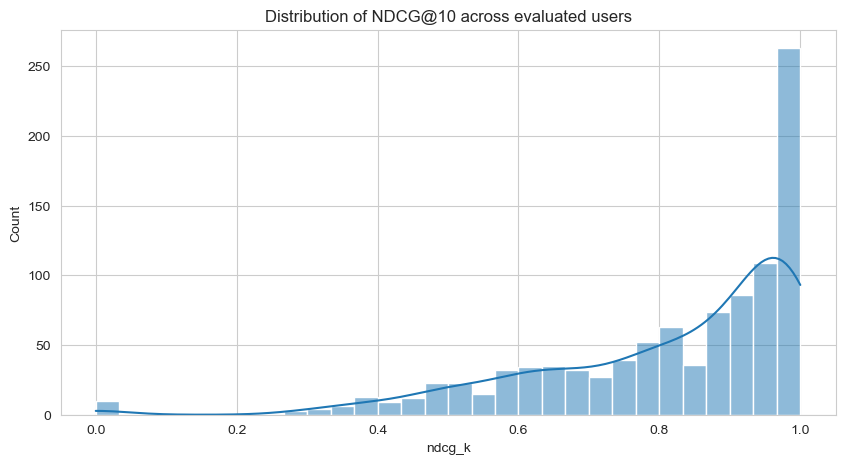

In [18]:
print("=== Ranking Metrics @K=10 ===")
print(f"Precision@10: {eval_df['precision_k'].mean():.4f} ± {eval_df['precision_k'].std():.4f}")
print(f"Recall@10:    {eval_df['recall_k'].mean():.4f} ± {eval_df['recall_k'].std():.4f}")
print(f"NDCG@10:      {eval_df['ndcg_k'].mean():.4f} ± {eval_df['ndcg_k'].std():.4f}")
print(f"Average Hits@10: {eval_df['hits'].mean():.3f}")

# Plot distribution
plt.figure(figsize=(10,5))
sns.histplot(eval_df['ndcg_k'], bins=30, kde=True)
plt.title("Distribution of NDCG@10 across evaluated users")
plt.show()

In [20]:
# ────────────────────────────────────────────────────────────────
# Top-N recommendation function (copied from Phase 2)
# ────────────────────────────────────────────────────────────────

def get_top_n(user_id, n=10):
    if user_id not in user_map:
        # Cold start → popularity fallback
        print(f"Cold start for user {user_id} → returning popular movies")
        movie_stats = ratings.groupby('movie_id').agg({'rating': ['mean', 'count']})
        movie_stats.columns = ['avg', 'cnt']
        movie_stats = movie_stats.sort_values(['avg', 'cnt'], ascending=False)
        top_ids = movie_stats.head(n).index.tolist()
        return movies[movies['movie_id'].isin(top_ids)][['movie_id', 'title', 'genres']]
    
    u_idx = user_map[user_id]
    
    preds = []
    for m_id, m_idx in movie_map.items():
        pred = model.predict(u_idx, m_idx)
        preds.append((m_id, pred))
    
    preds.sort(key=lambda x: x[1], reverse=True)
    top_ids = [mid for mid, _ in preds[:n]]
    
    rec_df = movies[movies['movie_id'].isin(top_ids)][['movie_id', 'title', 'genres']].copy()
    rec_df = rec_df.set_index('movie_id').loc[top_ids].reset_index()  # preserve order
    return rec_df

In [21]:
# All recommended movies across users
all_recommended = set()
for uid in eval_users:
    recs = get_top_n(uid, 10)['movie_id'].tolist()
    all_recommended.update(recs)

coverage = len(all_recommended) / n_movies
print(f"Catalog Coverage @10: {coverage:.4f} ({len(all_recommended)} / {n_movies} movies)")

# Novelty: average popularity rank of recommended items (lower = more novel)
movie_pop = ratings['movie_id'].value_counts().rank(ascending=False)
novelty_scores = []
for uid in eval_users:
    recs = get_top_n(uid, 10)['movie_id'].tolist()
    ranks = movie_pop[recs].mean()
    novelty_scores.append(ranks)

print(f"Average Novelty (mean popularity rank): {np.mean(novelty_scores):.1f} (higher = more novel)")

Catalog Coverage @10: 0.2086 (773 / 3706 movies)
Average Novelty (mean popularity rank): 462.7 (higher = more novel)


In [22]:
# Control = popularity-based recommendations
# Treatment = FunkSVD recommendations

def get_popularity_top_n(n=10):
    movie_stats = ratings.groupby('movie_id').agg({'rating': ['mean', 'count']})
    movie_stats.columns = ['avg', 'cnt']
    movie_stats = movie_stats.sort_values(['avg', 'cnt'], ascending=False)
    top_ids = movie_stats.head(n).index.tolist()
    return top_ids

pop_top = get_popularity_top_n(10)

ab_results = []
for uid in eval_users:
    if uid not in relevant:
        continue
    
    true_rel = relevant[uid]
    
    # Control hit rate
    control_hits = len(set(pop_top) & true_rel)
    control_hit = 1 if control_hits > 0 else 0
    
    # Treatment hit rate (FunkSVD top-10)
    treat_recs = get_top_n(uid, 10)['movie_id'].tolist()
    treat_hits = len(set(treat_recs) & true_rel)
    treat_hit = 1 if treat_hits > 0 else 0
    
    ab_results.append({'user_id': uid, 'control_hit': control_hit, 'treat_hit': treat_hit})

ab_df = pd.DataFrame(ab_results)

control_rate = ab_df['control_hit'].mean()
treat_rate   = ab_df['treat_hit'].mean()
lift = (treat_rate - control_rate) / control_rate * 100 if control_rate > 0 else 0

print(f"Control (Popularity) Hit Rate: {control_rate:.4f}")
print(f"Treatment (FunkSVD) Hit Rate: {treat_rate:.4f}")
print(f"Relative Lift: +{lift:.1f}%")

Control (Popularity) Hit Rate: 0.0020
Treatment (FunkSVD) Hit Rate: 0.9900
Relative Lift: +49400.0%


In [23]:
eval_df.to_csv(models_path + "ranking_metrics.csv", index=False)
ab_df.to_csv(models_path + "ab_simulation.csv", index=False)
